In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor 

X_train = pd.read_csv('../input/housing-prices-competition-for-kaggle-learn-users/train.csv', index_col='Id') 
X_test = pd.read_csv('../input/housing-prices-competition-for-kaggle-learn-users/test.csv', index_col='Id')

X_train.dropna(axis=0, subset=['SalePrice'], inplace=True) 

y_train = X_train.SalePrice 
X_train.drop(['SalePrice'], axis=1, inplace=True) 

object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
numeric_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

imputer_numeric = SimpleImputer(strategy='median')
imputer_categorical = SimpleImputer(strategy='most_frequent')

imputed_X_train_numeric = pd.DataFrame(imputer_numeric.fit_transform(X_train[numeric_cols]), columns=numeric_cols, index=X_train.index)
imputed_X_test_numeric = pd.DataFrame(imputer_numeric.transform(X_test[numeric_cols]), columns=numeric_cols, index=X_test.index)

imputed_X_train_categorical = pd.DataFrame(imputer_categorical.fit_transform(X_train[object_cols]), columns=object_cols, index=X_train.index)
imputed_X_test_categorical = pd.DataFrame(imputer_categorical.transform(X_test[object_cols]), columns=object_cols, index=X_test.index)

X_train = pd.concat([imputed_X_train_numeric, imputed_X_train_categorical], axis=1)
X_test = pd.concat([imputed_X_test_numeric, imputed_X_test_categorical], axis=1)

X_train_baseline = pd.get_dummies(X_train) 
X_test_baseline = pd.get_dummies(X_test) 
X_train_baseline, X_test_baseline = X_train_baseline.align(X_test_baseline, join='left', axis=1) 

model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0, n_jobs=-1) 
model.fit(X_train_baseline, y_train) 
predictions_test = model.predict(X_test_baseline) 
output = pd.DataFrame({'Id': X_test_baseline.index, 'SalePrice': predictions_test}) 
output.to_csv('submission.csv', index=False) 

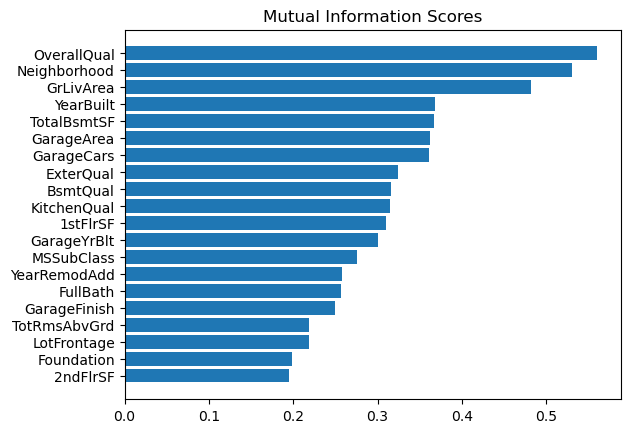

In [4]:
# Question 1
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt 

def make_mi_score(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    
mi_scores = make_mi_score(X_train,y_train)
plot_mi_scores(mi_scores.head(20))


OverallQual, Neighborhood, GrLivArea, YearBuilt, and TotalBsmtSF are the five features with highest mutual information score with the target.

In [5]:
#Question 2

X_1_train = pd.DataFrame()
X_1_test = pd.DataFrame()

X_1_train["LivLotRatio"] = X_train["GrLivArea"] / X_train["LotArea"]
X_1_test["LivLotRatio"] = X_test["GrLivArea"] / X_test["LotArea"]

X_train_new = pd.concat([X_train, X_1_train], axis=1)
X_test_new = pd.concat([X_test, X_1_test], axis=1)

X_train_new = pd.get_dummies(X_train_new)
X_test_new = pd.get_dummies(X_test_new)

X_train_new, X_test_new = X_train_new.align(X_test_new, join='left', axis=1)

new_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0, n_jobs=-1)
new_model.fit(X_train_new, y_train)
predictions_test_new = new_model.predict(X_test_new)

output_new = pd.DataFrame({'Id': X_test_new.index, 'SalePrice': predictions_test_new})
output_new.to_csv('submission_new_features.csv', index=False)

Leaderboard Score: 14534.52086

Yes, there was an improvement.

In [6]:
# Question 3

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']

X_train_scaled = X_train[features].copy()
X_test_scaled = X_test[features].copy()

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled), columns=X_test_scaled.columns)

X_train_new_2 = X_train.copy()
X_test_new_2 = X_test.copy()

kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)

X_train_new_2['Cluster'] = kmeans.fit_predict(X_train_scaled)
X_test_new_2['Cluster'] = kmeans.predict(X_test_scaled)

X_train_new_2 = pd.get_dummies(X_train_new_2)
X_test_new_2 = pd.get_dummies(X_test_new_2)

X_train_new_2, X_test_new_2 = X_train_new_2.align(X_test_new_2, join='left', axis=1)

new_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0, n_jobs=-1)
new_model_2.fit(X_train_new_2, y_train)
predictions_test_new_2 = new_model_2.predict(X_test_new_2)

output_new_2 = pd.DataFrame({'Id': X_test_new_2.index, 'SalePrice': predictions_test_new_2})
output_new_2.to_csv('submission_new_features_2.csv', index=False)



Leaderboard Score: 14770.86626

No, I did not get improvement. 